# Imports

Need to have jate.py in your folder

In [102]:
%run jate.py #will import everything

# The code

## memory wiping

In [103]:
%reset_selective -f  omega_1, total_time, epsilon, max_iter, time_steps, dt

In [104]:
%reset_selective -f  Lin, T_s, I

## Building parts

### Building the things to be calculated only once

In [105]:
def maker(omega_1, H_0, H_1, T_s, Lin, d=2, gamma=0.1):
    r"""maker
    Makes all the things that remain constant throught the program, but are 
    repeatedly used.
    

    Parameters
    ----------
    omega_1 : float
              frequency corresponding to half of the difference between 
              energy levels of the qubit
              
    H_0     : Qobj
              Bare Hamiltonian 
              
    H_1     : Qobj
              Interaction Hamiltonian 
              
    T_s     : Qobj
              Unitary to be implemented in the Hilbert space
    
    Lin     : Qobj
              Linbladian operators

    d       : int
              Dimension of the matrix. Defaults to 2
    
    gamma   : float
              Damping constantof the Linbladian

    
    Returns
    -------
    
    ih0     : Qobj
              $I\otimes H_{0}$
              
    ih1     : Qobj
              $I\otimes H_{1}$

    h0ci    : Qobj
              $H_{0}^{*}\otimes I $

    h1ci    : Qobj
              $H_{1}^{*}\otimes I $

    T       : Qobj
              Target unitary transformed to the Liouville space

    linbladian : Qobj
                 The full lindbladian term as it appears on transformation to 
                 the Liouville space.
        
    """
    I = identity(d)
    L_I = tensor(I, I)
    ih0 = tensor(I, H_0) 
    ih1 = tensor(I, H_1) 
    h0ci = tensor(H_0.conj(), I) 
    h1ci = tensor(H_1.conj(), I)
    x_k = ih1 - h1ci
    term1 = tensor(Lin.trans(), Lin)
    term2 = tensor(I, ((Lin.dag())*(Lin)))
    term3 = tensor(((Lin.trans())*(Lin.conj())), I)
    lindbladian = 1j*(gamma)*(term1 - 0.5*(term2 + term3))
    T = tensor(T_s.trans(), T_s) # Transforming $T_{s}$ to liouville space
    
    
    return ih0, ih1, h0ci, h1ci, x_k, lindbladian, T, L_I

In [106]:
omega_1 = 0.5
H_0 = sigmaz() 
H_1 = sigmay()
T_s = sigmax() 
Lin = sigmaz()
ih0, ih1, h0ci, h1ci, x_k, lindbladian, T, L_I  = maker(omega_1,
                                                  H_0, H_1, T_s, 
                                                  Lin, d=2, gamma=0.1)

In [107]:
L_I

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

### Building $A(t)$

In [108]:
def A(xi):
    r"""making $A(t)$"""
    A = ih0 - h0ci + xi*(ih1 - h1ci) + lindbladian
    return A

In [109]:
A(0.5)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.+0.j   0.-0.5j  0.-0.5j  0.+0.j ]
 [ 0.+0.5j -2.-0.2j  0.+0.j   0.-0.5j]
 [ 0.+0.5j  0.+0.j   2.-0.2j  0.-0.5j]
 [ 0.+0.j   0.+0.5j  0.+0.5j  0.+0.j ]]

### Building $L(t)$ and the Identity in the Liouville space

In [110]:
def L(xi, dt):
    r"""Making $L(t) from $A(t)$"""
    L = (-1j*A(xi)*dt).expm()
    return L

In [111]:
L(0.5, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99999750e-01+0.00000000e+00j -4.99949587e-04-4.99933130e-07j
  -4.99949587e-04+4.99933130e-07j  2.49983230e-07+0.00000000e+00j]
 [ 4.99949587e-04+4.99933130e-07j  9.99797770e-01+1.99959837e-03j
  -2.49966565e-07+0.00000000e+00j -4.99949587e-04-4.99933130e-07j]
 [ 4.99949587e-04-4.99933130e-07j -2.49966565e-07+0.00000000e+00j
   9.99797770e-01-1.99959837e-03j -4.99949587e-04+4.99933130e-07j]
 [ 2.49983230e-07+0.00000000e+00j  4.99949587e-04+4.99933130e-07j
   4.99949587e-04-4.99933130e-07j  9.99999750e-01+0.00000000e+00j]]

## Major functions

### Major functions 1

In [112]:
# building the function to optimize (optimizee)
def L_vec(xi_vec, dt):
    r"""Building the vector of differential $L(t)$"""
    L_vec = [L(xi, dt) for xi in xi_vec] 
    return L_vec

In [113]:
def fidelity_calc(A, B):
    r"""Making a generalised fidelity function"""
    first_part = (A - B).dag()
    second_part = (A - B)
    f_int = (first_part* second_part)
    f = f_int.tr()
    return f

In [114]:
def L_full_maker(xi_vec, dt):
    r"""Building the $L(t)$ for the total time $t$"""
    xi_vec_size = xi_vec.size # finding the size of xi
    L_full = L_I # Identity for the for loop of L
    L_v = L_vec(xi_vec, dt) # calling L_vec
    for i in range(xi_vec_size): # generating L_full
        L_full = L_full*L_v[xi_vec_size - 1 - i]
    return L_full

In [115]:
def F(xi_vec, dt):
    r"""Using the fidelity metric to find out the closeness between $T$
    and $L(t)$"""
    L_full = L_full_maker(xi_vec, dt)
    F = real(-fidelity_calc(T, L_full))   
    return F

### Testing major functions 1

In [116]:
fidelity_calc(sigmax(), sigmay())

4.0

In [117]:
fidelity_calc(sigmay(), sigmay())

0.0

In [118]:
xi_vec_test = array([1.0, 2.0])
xi_vec_test

array([1., 2.])

In [119]:
xi_vec_test.size

2

In [120]:
w_vec = [xi**2 for xi in xi_vec_test]
w_vec

[1.0, 4.0]

In [121]:
# F(xi_vec, dt)
F(xi_vec_test, 0.001)

-7.998400634487143

In [122]:
L_v = L_vec(xi_vec_test, 0.001)

In [123]:
L_v

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99999000e-01+0.00000000e+00j -9.99898674e-04-9.99866010e-07j
   -9.99898674e-04+9.99866010e-07j  9.99932670e-07+0.00000000e+00j]
  [ 9.99898674e-04+9.99866010e-07j  9.99797021e-01+1.99959737e-03j
   -9.99866010e-07+0.00000000e+00j -9.99898674e-04-9.99866010e-07j]
  [ 9.99898674e-04-9.99866010e-07j -9.99866010e-07+0.00000000e+00j
    9.99797021e-01-1.99959737e-03j -9.99898674e-04+9.99866010e-07j]
  [ 9.99932670e-07+0.00000000e+00j  9.99898674e-04+9.99866010e-07j
    9.99898674e-04-9.99866010e-07j  9.99999000e-01+0.00000000e+00j]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99996000e-01+0.00000000e+00j -1.99979335e-03-1.99973002e-06j
   -1.99979335e-03+1.99973002e-06j  3.99972668e-06+0.00000000e+00j]
  [ 1.99979335e-03+1.99973002e-06j  9.99794021e-01+1.99959337e-03j
   -3.99946004e-06+0.00000000e+00j -1.99979335e-03-1.99973

### Major Functions 2

In [124]:
def L_comma_k_maker(xi_vec, k, dt):
    r"""Making of the derivative of full $L(t)$ at time $t_{k}$"""
    N = xi_vec.size 
    # Determining the size of xi, and thus the time_steps indirectly.
    L_v = L_vec(xi_vec, dt)# Making of the full $L(t)$
    inner_part = L_I # Beginner for the for loop
    for i in range(N):
        if i == ( N - 1 - k ):
            # The step at which $X_{k}(t)$ has to be inserted 
            inner_part = inner_part*x_k*L_v[k - 1]
        else:
            # Usual multiplications of $L_{k}$
            inner_part = inner_part*L_v[N - 1 - i]
    l_comma_k = inner_part
    return l_comma_k
    

In [125]:
# L_comma_k_maker(xi_vec, k, dt)
L_comma_k_maker(xi_vec_test, 2, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99991001e-01+0.00000000e+00j -2.99927211e-03-6.99796565e-06j
  -2.99927211e-03+6.99796565e-06j  8.99882878e-06+0.00000000e+00j]
 [ 2.99947607e-03+4.99878084e-06j  9.99583086e-01+3.99836500e-03j
  -8.99749372e-06+5.99798035e-09j -2.99947607e-03-4.99878084e-06j]
 [ 2.99947607e-03-4.99878084e-06j -8.99749372e-06-5.99798035e-09j
   9.99583086e-01-3.99836500e-03j -2.99947607e-03+4.99878084e-06j]
 [ 8.99882878e-06+0.00000000e+00j  2.99927211e-03+6.99796565e-06j
   2.99927211e-03-6.99796565e-06j  9.99991001e-01+0.00000000e+00j]]

In [126]:
def updater(xi_vec, dt, epsilon):
    r"""Implementing the GRAPE update step"""
    xi_vec_size = xi_vec.size # finding the size of xi
    L_full = L_full_maker(xi_vec, dt)
    di = []
    for k in range(xi_vec_size):
        # Building the thing to be added to the old function
        L_comma_k = L_comma_k_maker(xi_vec, k, dt)
        differentiated = T - L_comma_k
        plain = T - L_full
        c = -differentiated.dag()*plain
        d = -plain.dag()*differentiated
        inside = c.tr() + d.tr()
        di.append(epsilon*inside)

    diff = array(di)
    xi_new_vec = xi_vec + diff
    return diff, xi_new_vec
    

In [127]:
#  updater(xi_vec, dt, epsilon)
updater(xi_vec_test, 0.001, 0.001)

(array([-0.008+0.j, -0.008+0.j]), array([0.992+0.j, 1.992+0.j]))

In [128]:
def terminator(max_iter, time_steps, total_time, epsilon):
    r"""Brief description of the function"""
    
    xi_initial =  1000*random_sample((time_steps,))
    dt = total_time/time_steps
    xi_diff, xi_new_vec = updater(xi_initial, dt, epsilon)
    
    for i in range(max_iter):
        if amax(xi_diff) < epsilon**2 :
            
            xi_final = xi_new_vec
            break
        else :
            xi_diff, xi_new_vec = updater(xi_new_vec, dt, epsilon)
            print(i)
            print(amax(xi_diff))
            
        
    xi_final = xi_new_vec    
    return xi_final

# Running stuff

### Try

In [129]:
total_time = 1*pi/omega_1
time_steps = 2
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: -4.220632
         Iterations: 70
         Function evaluations: 150
[308.49311349  83.76258283]


In [130]:
res

 final_simplex: (array([[308.49311349,  83.76258283],
       [308.49311348,  83.76258284],
       [308.49311348,  83.76258283]]), array([-4.22063214, -4.22063214, -4.22063214]))
           fun: -4.220632137502155
       message: 'Optimization terminated successfully.'
          nfev: 150
           nit: 70
        status: 0
       success: True
             x: array([308.49311349,  83.76258283])

In [131]:
F(res.x, dt)

-4.220632137502155

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1e0cd9b00>)

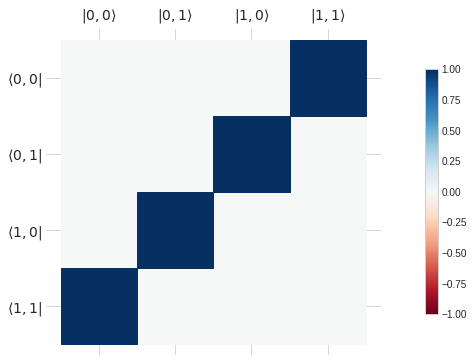

In [132]:
hinton(T)

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1e0c2fba8>)

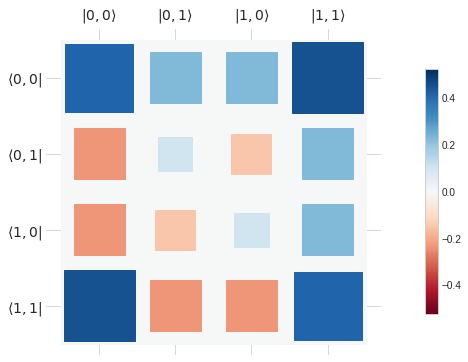

In [133]:
hinton(L_full_maker(res.x, dt))

In [134]:
L_full_maker(res.x, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.47793678+0.j         -0.26578292-0.00157227j -0.26578292+0.00157227j
   0.52206322+0.j        ]
 [ 0.26580291-0.00096517j  0.1199417 +0.00229615j -0.1646767 +0.00394195j
  -0.26580291+0.00096517j]
 [ 0.26580291+0.00096517j -0.1646767 -0.00394195j  0.1199417 -0.00229615j
  -0.26580291-0.00096517j]
 [ 0.52206322+0.j          0.26578292+0.00157227j  0.26578292-0.00157227j
   0.47793678+0.j        ]]

### Try

In [135]:
total_time = 10*pi/omega_1
time_steps = 2
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: -3.000015
         Iterations: 61
         Function evaluations: 148
[548.57410329 603.64916228]


In [136]:
res

 final_simplex: (array([[548.57410329, 603.64916228],
       [548.57410329, 603.64916228],
       [548.57410329, 603.64916228]]), array([-3.00001463, -3.00001463, -3.00001463]))
           fun: -3.0000146301962376
       message: 'Optimization terminated successfully.'
          nfev: 148
           nit: 61
        status: 0
       success: True
             x: array([548.57410329, 603.64916228])

In [137]:
F(res.x, dt)

-3.0000146301962376

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1e0b29cf8>)

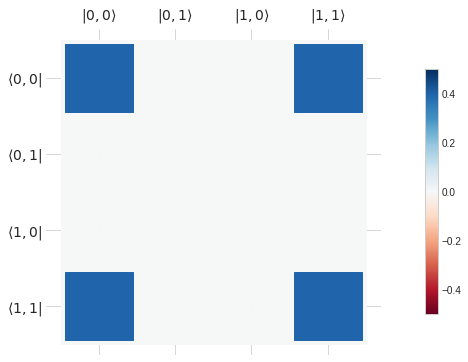

In [138]:
hinton(L_full_maker(res.x, dt))

In [139]:
L_full_maker(res.x, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 5.00000028e-01+0.00000000e+00j -9.33702293e-04+3.56337611e-09j
  -9.33702293e-04-3.56337612e-09j  4.99999972e-01+0.00000000e+00j]
 [ 9.33702014e-04+3.38120045e-09j  1.60174911e-06+3.24210132e-06j
  -1.88573603e-06-1.61997927e-07j -9.33702014e-04-3.38120149e-09j]
 [ 9.33702014e-04-3.38120045e-09j -1.88573603e-06+1.61997927e-07j
   1.60174911e-06-3.24210132e-06j -9.33702014e-04+3.38120149e-09j]
 [ 4.99999972e-01+0.00000000e+00j  9.33702293e-04-3.56337658e-09j
   9.33702293e-04+3.56337656e-09j  5.00000028e-01+0.00000000e+00j]]

### Try

In [140]:
total_time = 10*pi/omega_1
time_steps = 20
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

[809.72475096 943.77349537 168.99299284  21.2127754  452.01574249
 680.68687196 717.54973965 483.06126497 249.1471718  923.80783329
 503.21663303 803.77925697 169.69695273 496.83231259 271.67937631
 991.70926902 719.14032705 529.89605505 397.03559005 194.22284693]


In [141]:
res

 final_simplex: (array([[809.72475096, 943.77349537, 168.99299284,  21.2127754 ,
        452.01574249, 680.68687196, 717.54973965, 483.06126497,
        249.1471718 , 923.80783329, 503.21663303, 803.77925697,
        169.69695273, 496.83231259, 271.67937631, 991.70926902,
        719.14032705, 529.89605505, 397.03559005, 194.22284693],
       [809.7244188 , 943.77399134, 168.99297186,  21.21270266,
        452.0165769 , 680.68634418, 717.54965337, 483.06023528,
        249.14863581, 923.80756017, 503.21591977, 803.78062241,
        169.69655512, 496.83215647, 271.67898656, 991.70945236,
        719.13978115, 529.8952776 , 397.03642572, 194.22321428],
       [809.72499285, 943.77284012, 168.99306021,  21.21262627,
        452.01729585, 680.68541969, 717.54826278, 483.06164624,
        249.14903018, 923.80707616, 503.21648127, 803.78016379,
        169.69746518, 496.83114924, 271.67912704, 991.71240115,
        719.13770899, 529.89435228, 397.03645007, 194.22278382],
       [809.72442353

In [142]:
res.success

False

In [143]:
res.nit

3017

In [144]:
res.nfev

4000

In [145]:
res.status

1

In [146]:
res.message

'Maximum number of function evaluations has been exceeded.'

In [147]:
F(res.x, dt)

-3.0000413261590784

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1e0a74d30>)

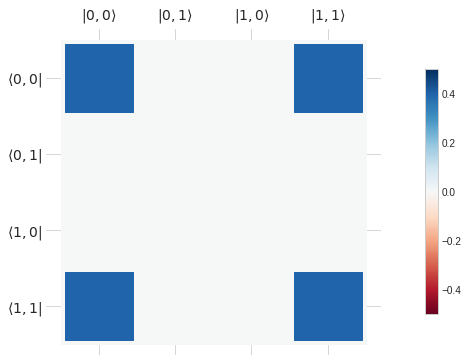

In [148]:
hinton(L_full_maker(res.x, dt))

In [149]:
L_full_maker(res.x, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 5.00130718e-01+0.00000000e+00j -9.23354795e-04+1.03933603e-05j
  -9.23354794e-04-1.03933603e-05j  4.99869282e-01+0.00000000e+00j]
 [ 9.23478067e-04+1.70175388e-06j  1.25804094e-04-1.12816993e-05j
   1.22124418e-04+2.07674819e-05j -9.23478067e-04-1.70175388e-06j]
 [ 9.23478067e-04-1.70175388e-06j  1.22124418e-04-2.07674819e-05j
   1.25804094e-04+1.12816993e-05j -9.23478067e-04+1.70175388e-06j]
 [ 4.99869282e-01+0.00000000e+00j  9.23354794e-04-1.03933603e-05j
   9.23354795e-04+1.03933603e-05j  5.00130718e-01+0.00000000e+00j]]

### Try

In [150]:
total_time = 10*pi/omega_1
time_steps = 50
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

[568.49557574 691.55516111 772.24620699 887.70307693 533.2628669
 824.24416981 761.32011196 477.63844375 483.08437526 606.80702529
 366.90313424 655.50216974  36.99607036 594.18227965 188.37419335
 847.83384788 323.36579831 781.09320435 759.38011293 415.39958912
 516.62391369 707.31959114 619.51924493 235.99598997  14.62338182
 905.55526583 803.83984705 179.32622951 611.60452813  28.44328694
 553.18429186 254.21599906 820.9470613  725.75231031  79.49625294
 920.52223329  80.82630509 658.40596912 892.21544894 650.24362819
 870.65127975 191.09255338 551.06506416 625.65334602 358.04526168
 919.44591901 629.93218939 439.59247306 566.60675987 254.51561459]


In [151]:
res.success

False

In [152]:
res.nit

8294

In [153]:
res.nfev

10000

In [154]:
res.status

1

In [155]:
res.message

'Maximum number of function evaluations has been exceeded.'

# try

In [156]:
total_time = 10*pi/omega_1
time_steps = 50
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

[852.52741537  80.58802455 845.43020221 412.90520188 291.67746646
 458.07321083 348.06305393 833.22721737 299.84397601 177.15488341
 569.69450444 575.66461517  93.3952996  869.29179327 942.31293914
 780.10664925 623.2507488  924.18731761 249.45080928 978.17345738
 886.30956593 511.2082733  669.7517135  381.20426063 421.60869191
 337.20955942  28.4480805  125.36543636 125.62063232 324.75123216
 300.55073266 201.24806078 347.29877558 715.60326794 194.45368455
 756.50732736 578.58144379 798.88945726 722.79070646 384.42824292
 385.6225258  150.00065328  43.04351192 487.38450275 675.26308391
 849.21218835 516.22306629 568.02728792 803.44248679 855.48627024]


In [157]:
res.success

False

In [158]:
res.nit

8356

In [159]:
res.nfev

10000

In [160]:
res.status

1

In [161]:
res.message

'Maximum number of function evaluations has been exceeded.'

In [162]:
F(res.x, dt)

-3.000051664992832

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1e0956e80>)

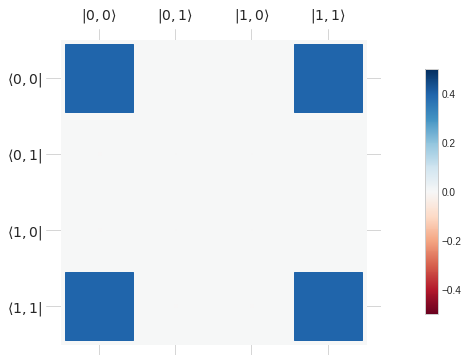

In [163]:
hinton(L_full_maker(res.x, dt))

In [164]:
L_full_maker(res.x, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 4.99942392e-01+0.00000000e+00j -9.30055603e-04-1.09306236e-05j
  -9.30055603e-04+1.09306236e-05j  5.00057608e-01+0.00000000e+00j]
 [ 9.30005406e-04+9.62904003e-06j -6.58221377e-05+2.46716522e-05j
  -6.87855634e-05-2.38255123e-06j -9.30005406e-04-9.62904003e-06j]
 [ 9.30005406e-04-9.62904003e-06j -6.87855634e-05+2.38255123e-06j
  -6.58221377e-05-2.46716522e-05j -9.30005406e-04+9.62904003e-06j]
 [ 5.00057608e-01+0.00000000e+00j  9.30055603e-04+1.09306236e-05j
   9.30055603e-04-1.09306236e-05j  4.99942392e-01+0.00000000e+00j]]

### Try

In [165]:
total_time = 10*pi/omega_1
time_steps = 70
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

[2.86737303e+02 9.11629976e+02 1.79975765e+02 6.70084112e+02
 3.50737971e+02 9.67170770e+02 9.38133376e+02 9.48525439e+01
 4.56014183e+02 1.03204961e+03 2.90408045e+02 4.08989562e+02
 5.66530308e+02 7.92961976e+02 3.04432106e+02 6.18665935e+01
 9.37128053e+02 2.66624278e+02 9.50936568e+02 3.71176082e+02
 8.02507240e+02 9.47113844e+01 5.00293836e+02 5.54337497e+02
 7.17219468e+02 3.85613320e+02 4.14791160e+00 2.24341648e+02
 5.51625365e+02 4.60904082e+02 8.75134729e+02 4.15691444e+02
 2.94614173e+02 3.50110764e+02 7.92468572e+02 6.98833717e+02
 6.63474185e+02 8.81395093e+02 6.76070871e+02 6.05630728e+02
 5.02073100e+01 7.61314689e+02 6.35148927e+02 6.45358439e+02
 1.18870049e+02 2.65370266e+02 7.95015150e+02 5.30436867e+02
 2.19228032e-01 5.63966738e+02 8.55917906e+02 1.51332041e+00
 4.38311643e+02 7.46532425e+02 8.16370095e+02 1.56994197e+01
 2.82244976e+02 1.74213554e+02 8.43498883e+02 4.71980431e+02
 4.14318082e+02 1.80185911e+02 2.73056101e+02 5.32566519e+02
 5.91203668e+02 1.528080

In [166]:
res.success

False

In [167]:
res.nit

12305

In [168]:
res.nfev

14000

In [169]:
res.status

1

In [170]:
res.message

'Maximum number of function evaluations has been exceeded.'

In [171]:
F(res.x, dt)

-3.0064608252508824

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1e09ec940>)

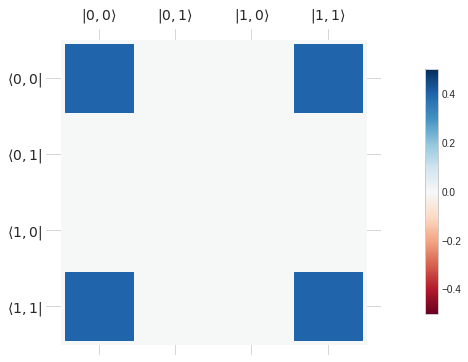

In [172]:
hinton(L_full_maker(res.x, dt))

In [173]:
L_full_maker(res.x, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 5.00958751e-01+0.00000000e+00j  1.47260480e-05-2.42607209e-05j
   1.47260481e-05+2.42607209e-05j  4.99041249e-01+0.00000000e+00j]
 [ 1.34526100e-04+3.52897905e-05j -6.56746056e-04+3.96794122e-05j
  -6.55084770e-04+1.98116719e-06j -1.34526100e-04-3.52897905e-05j]
 [ 1.34526100e-04-3.52897905e-05j -6.55084770e-04-1.98116719e-06j
  -6.56746056e-04-3.96794122e-05j -1.34526100e-04+3.52897905e-05j]
 [ 4.99041249e-01+0.00000000e+00j -1.47260481e-05+2.42607209e-05j
  -1.47260480e-05-2.42607209e-05j  5.00958751e-01+0.00000000e+00j]]

### Try

In [174]:
total_time = 4*pi/omega_1
time_steps = 50
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

[3.10706942e+01 1.71661072e+02 4.96809313e+02 9.71691473e+02
 7.50886130e+02 6.89623383e+01 1.02322539e+02 2.08787251e+02
 8.32069280e+02 9.09327096e+01 7.16608116e+02 2.62616372e+02
 7.99120148e-01 4.13789811e+02 8.28145319e+02 7.83119551e+02
 6.98340896e+02 9.62622863e+02 4.03711600e+02 3.55991338e+02
 7.90004260e+02 2.27247404e+02 8.54305436e+02 4.87159236e+02
 8.88903806e+00 7.48168132e+01 5.64375641e+02 9.46723329e+02
 5.18818426e+02 6.60802644e+02 4.44540515e+02 3.86244208e+02
 2.30531296e+01 8.05730177e+02 9.35338435e+02 8.72545898e+02
 6.70931711e+02 9.73244930e+01 5.08194568e+02 5.85807234e+02
 9.09190156e+02 1.16914663e+02 8.40529495e+02 3.69015358e+02
 2.68798125e+02 3.72061407e+02 6.91754763e+02 5.45786893e+02
 8.45484088e+02 1.29990769e+02]


In [175]:
res.success

False

In [176]:
res.nit

8561

In [177]:
res.nfev

10000

In [178]:
res.status

1

In [179]:
res.message

'Maximum number of function evaluations has been exceeded.'

In [181]:
F(res.x, dt)

-3.118236654375054

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1e0ea9d68>)

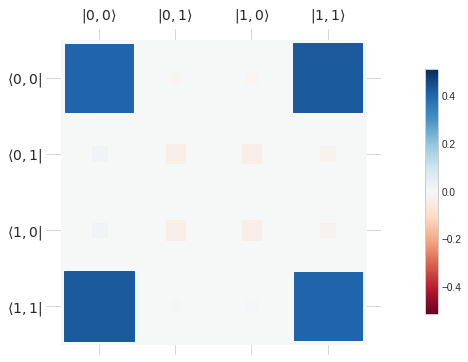

In [182]:
hinton(L_full_maker(res.x, dt))

In [183]:
L_full_maker(res.x, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.48720294+0.j          0.01212246+0.01822508j  0.01212246-0.01822508j
   0.51279706+0.j        ]
 [-0.01178047-0.00630556j -0.03947225+0.0066154j  -0.03993338-0.00252488j
   0.01178047+0.00630556j]
 [-0.01178047+0.00630556j -0.03993338+0.00252488j -0.03947225-0.0066154j
   0.01178047-0.00630556j]
 [ 0.51279706+0.j         -0.01212246-0.01822508j -0.01212246+0.01822508j
   0.48720294+0.j        ]]

### Try

In [184]:
total_time = 10*pi/omega_1
time_steps = 100
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

[226.83291309 312.81435953 501.77844453 601.28217192  53.80032877
 167.76636016 302.26228172 335.12137095 318.95500147 266.46389058
 825.45210804  71.71940408 890.35205434 830.78096938 182.91230712
 212.43241318  88.69960523 582.81847503 525.6371177  629.1219515
 945.58042661  11.66089477 171.19504663  40.91258786 516.64654072
 707.42600113 150.50465288 391.2405175  346.96842478 974.78051796
 594.11131398 664.25729123  49.28968793 143.35534293  51.81735592
 793.10607987  69.6525971  784.42909008 488.00596026 825.77887031
  41.24330211 167.18230788 388.77367619 724.7851242  600.06743316
   9.63939838  67.11789631 911.7055435  919.16602172  24.09296792
 693.76139565 764.8661289  396.31003728 653.29797886  89.3452998
 588.49914555 208.98077443 361.41066166 250.21122437 280.79046075
 560.74417364 934.74365484 876.05675858 829.36008234  19.126736
 833.10554457 750.02290947 537.14864619 208.05022488 207.02749251
 618.95109998 601.82430529 153.58516742 656.02885946 248.72161701
 480.16657554 

In [185]:
res.success

False

In [186]:
res.nit

17731

In [187]:
res.nfev

20000

In [188]:
res.status

1

In [189]:
res.message

'Maximum number of function evaluations has been exceeded.'

In [190]:
F(res.x, dt)

-3.0001710681880445

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1e0811470>)

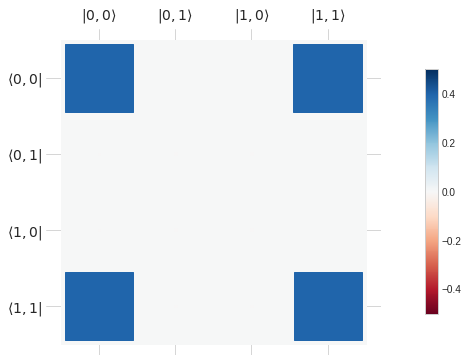

In [191]:
hinton(L_full_maker(res.x, dt))

In [192]:
L_full_maker(res.x, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.49930858+0.00000000e+00j -0.00059366+3.40454116e-05j
  -0.00059366-3.40454116e-05j  0.50069142+0.00000000e+00j]
 [ 0.00059381+5.09685049e-06j -0.0007287 -4.02413837e-05j
  -0.00073247+3.45000141e-06j -0.00059381-5.09685049e-06j]
 [ 0.00059381-5.09685049e-06j -0.00073247-3.45000141e-06j
  -0.0007287 +4.02413837e-05j -0.00059381+5.09685049e-06j]
 [ 0.50069142+0.00000000e+00j  0.00059366-3.40454116e-05j
   0.00059366+3.40454116e-05j  0.49930858+0.00000000e+00j]]

# Running stuff

### Try1

In [193]:
total_time = pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1e0cf14e0>)

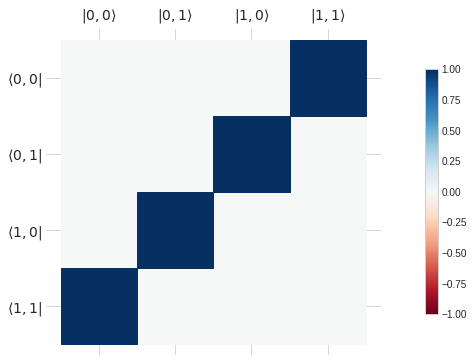

In [194]:
hinton(T)

In [195]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([293.80055732+0.j, 659.18519834+0.j, 764.52195323+0.j,
       552.73424835+0.j, 119.44956651+0.j, 219.13707857+0.j,
       314.48123997+0.j,  82.76970153+0.j, 226.88901487+0.j,
       168.25706911+0.j, 427.75952876+0.j, 747.88649201+0.j,
       565.80859523+0.j, 981.84409999+0.j, 110.75768951+0.j,
       382.91743902+0.j, 583.06839296+0.j, 291.86471636+0.j,
       809.89573275+0.j, 872.48422396+0.j])

In [196]:
F(xi_opt, dt)

-4.21852635565865

In [197]:
max_iter

10

In [198]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [199]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.24886202+0.j          0.09008089-0.0023736j   0.09008089+0.0023736j
   0.75113798+0.j        ]
 [-0.0901676 +0.00092756j -0.10864315-0.00044453j -0.39322055-0.00538541j
   0.0901676 -0.00092756j]
 [-0.0901676 -0.00092756j -0.39322055+0.00538541j -0.10864315+0.00044453j
   0.0901676 +0.00092756j]
 [ 0.75113798+0.j         -0.09008089+0.0023736j  -0.09008089-0.0023736j
   0.24886202+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1e06b8550>)

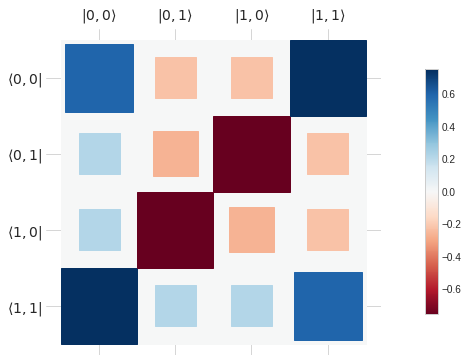

In [200]:
hinton(L_full_maker(xi_opt, dt))

# Next chapter

## memory clear (uses regex, so be careful)

In [201]:
%reset_selective -f var1, var2  # replace var1, var2 with your defined ones

## sub topic 2

In [202]:
cnot()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

## sub topic 3

### sub sub topic 1